# OBJECT DETECTION : Custom Trained Model

## Required Packages

In [16]:
import os
import wget

## Pre-Trained-Model

In [17]:
pt_model_name = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
pt_model_url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
pt_model_path = os.path.join('Tensorflow', 'pre_trained_model')

In [ ]:

wget.download(pt_model_url)
!move {model_name+'.tar.gz'} {pt_model_path}
!cd {model_path} && tar -zxvf {pt_model_name+'.tar.gz'}
os.remove(os.path.join(pt_model_path, f"{pt_model_name}.tar.gz"))

        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


## Label Map

In [18]:

labels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'HiFive', 'id':3}, {'name':'Victory', 'id':4}]

labelmap_path = os.path.join('annotation','label_map.pbtxt')

with open(labelmap_path, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## TF Record

In [19]:
tfrecord = 'create_tfrecord.py'
train_path = os.path.join('Images', 'train')
test_path = os.path.join('Images', 'test')
labelmap_path = os.path.join('annotation', 'label_map.pbtxt')
train_tfrecord = os.path.join('annotation', 'train.record')
test_tfrecord = os.path.join('annotation', 'test.record')

In [ ]:
# Generate tfRecord for train data
!python {tfrecord} -x {train_path}  -l {labelmap_path} -o {train_tfrecord}
# Generate tfRecord for test data
!python {tfrecord} -x {test_path}  -l {labelmap_path} -o {test_tfrecord}

Successfully created the TFRecord file: annotation\train.record
Successfully created the TFRecord file: annotation\test.record


## Modify Configuration File

In [20]:
### copy config file from pretrained model to pipeline

!copy {os.path.join(pt_model_path, pt_model_name, 'pipeline.config')} {'pipeline'}

        1 file(s) copied.


In [21]:
# Modification Values and paths
pre_config_path = os.path.join(pt_model_path, pt_model_name, 'pipeline.config')
config_path = os.path.join('pipeline', 'pipeline.config')
checkpoint_path = os.path.join(pt_model_path, pt_model_name, 'checkpoint\ckpt-0')
batch_size = 16
num_steps = 2000

In [24]:
# Required Packages
import tensorflow as tf
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [25]:
# Open Configuration file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(pre_config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [26]:
# Modify values and paths
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = batch_size
pipeline_config.train_config.num_steps = num_steps
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = num_steps
pipeline_config.train_config.fine_tune_checkpoint = checkpoint_path
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= labelmap_path
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [train_tfrecord]
pipeline_config.eval_input_reader[0].label_map_path = labelmap_path
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [test_tfrecord]

In [27]:
# Save Configuration file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(config_path, "wb") as f:
    f.write(config_text)

In [5]:
# View Modified Configuration file
%pycat pipeline\pipeline.config

model {
  ssd {
    num_classes: 4
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.01
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.997
          scale: true
          epsilon: 0.001
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      arg

## Train the Model

In [ ]:
## Training the Model

In [11]:
exp_model_path = os.path.join('exported_model', 'costume_trained_model')
training_script = 'Tensorflow\models\research\object_detection\model_main_tf2.py'


In [ ]:
# Training command

In [ ]:
command = f"python {training_script} --pipeline_config_path={config_path} --model_dir={exp_model_path} --num_train_steps={num_steps}"

In [6]:
# Training Script
command

NameError: name 'command' is not defined

In [ ]:
# python Tensorflow\\models\research\\object_detection\\model_main_tf2.py --pipeline_config_path=pipeline\\pipeline.config --model_dir=exported_model\\costume_trained_model --num_train_steps=2000

## Evaluation command

In [ ]:
command = f'python {training_script} --model_dir={exp_model_path} --pipeline_config_path={config_path} --checkpoint_dir={exp_model_path}'

In [ ]:
command

'python Tensorflow\\models\research\\object_detection\\model_main_tf2.py --model_dir=exported_model\\costume_trained_model --pipeline_config_path=pipeline\\pipeline.config --checkpoint_dir=exported_model\\costume_trained_model'

In [ ]:
# python Tensorflow\\models\research\\object_detection\\model_main_tf2.py --model_dir=exported_model\\costume_trained_model --pipeline_config_path=pipeline\\pipeline.config --checkpoint_dir=exported_model\\costume_trained_model

## Load Model

In [28]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [29]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(config_path)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(exp_model_path, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## Detect from Image

In [5]:
pwd

'c:\\Users\\asbpi\\Desktop\\ASB\\Data_Science\\Projects\\MY Projects\\Object_Detection'

In [6]:
# %run custom_model_load.py

In [7]:

import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

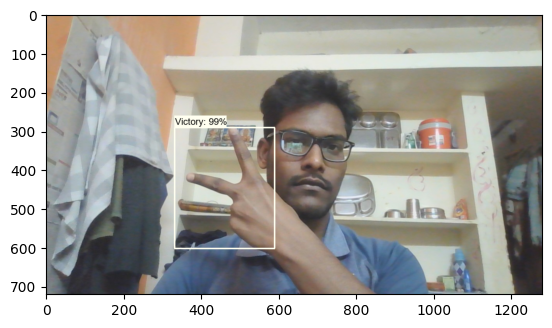

In [8]:
image = os.path.join('Input/Images/WIN_20231114_19_29_02_Pro.jpg')
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path)


img = cv2.imread(image)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

## Detect from Webcam

In [32]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

ValueError: in user code:

    File "C:\Users\asbpi\AppData\Local\Temp\ipykernel_1656\1845736020.py", line 11, in detect_fn  *
        image, shapes = detection_model.preprocess(image)
    File "c:\Users\asbpi\anaconda3\envs\ds-9\lib\site-packages\object_detection\meta_architectures\ssd_meta_arch.py", line 485, in preprocess  *
        normalized_inputs, self._image_resizer_fn)
    File "c:\Users\asbpi\anaconda3\envs\ds-9\lib\site-packages\object_detection\utils\shape_utils.py", line 492, in resize_images_and_return_shapes  *
        outputs = static_or_dynamic_map_fn(
    File "c:\Users\asbpi\anaconda3\envs\ds-9\lib\site-packages\object_detection\utils\shape_utils.py", line 246, in static_or_dynamic_map_fn  *
        outputs = [fn(arg) for arg in tf.unstack(elems)]
    File "c:\Users\asbpi\anaconda3\envs\ds-9\lib\site-packages\object_detection\core\preprocessor.py", line 3330, in resize_image  *
        new_image = tf.image.resize_images(

    ValueError: 'images' must have either 3 or 4 dimensions.


: 